# Next code was launched under Python 3

# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [25]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [27]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [28]:
print(df.shape, df.is_blocked.mean())
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [29]:
print("Blocked ratio",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio 0.228222107326
Count: 1204949


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [30]:
#downsample

ddf = df.sort_values(by="is_blocked",ascending=False) # sort by is_blocked
ddf2 = ddf[:550000] 
# < downsample data so that both classes have approximately equal ratios>

df = ddf2
df = df.sample(frac=1).reset_index(drop=True)

print("Blocked ratio:",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio: 0.499992727273
Count: 550000


In [31]:
type(df)

pandas.core.frame.DataFrame

In [32]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print("All tests passed")

All tests passed


In [33]:
#In case your RAM-o-meter is in the red
if very_low_ram:
    data = data[::2]

NameError: name 'very_low_ram' is not defined

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [34]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict

tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

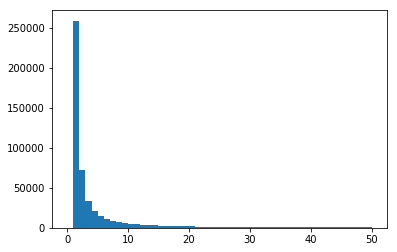

In [35]:
#Word frequency distribution, just for kicks
_=plt.hist(list(token_counts.values()),range=[0,50],bins=50)

In [36]:
token_counts

Counter({'квартира': 86510,
         'улучшенной': 855,
         'планировки': 2274,
         'лоджия': 7365,
         '6': 41302,
         'м': 54913,
         'застеклена': 1904,
         'большая': 5662,
         'кухня': 13938,
         'комнаты': 10633,
         'изолированные': 2007,
         'на': 373617,
         'кухне': 2268,
         'в': 594138,
         'зале': 585,
         'и': 573780,
         'коридоре': 559,
         'сделан': 3375,
         'хороший': 7838,
         'ремонт': 26560,
         'выровнены': 328,
         'стены': 2673,
         'натяжные': 1471,
         'потолки': 3532,
         'пол': 4571,
         'кафель': 2922,
         'ламинат': 3720,
         'остальных': 293,
         'комнатах': 771,
         'линолеум': 1512,
         'во': 14944,
         'всех': 12059,
         'пластиковые': 6490,
         'окна': 15788,
         'электропроводка': 420,
         'заменена': 533,
         'полностью': 10429,
         'ванной': 1444,
         'новая': 18678

In [37]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
tokens = [key for key, value in token_counts.items() if value >= min_count]


In [38]:
len(tokens)

87890

In [39]:
tokens

['квартира',
 'улучшенной',
 'планировки',
 'лоджия',
 '6',
 'м',
 'застеклена',
 'большая',
 'кухня',
 'комнаты',
 'изолированные',
 'на',
 'кухне',
 'в',
 'зале',
 'и',
 'коридоре',
 'сделан',
 'хороший',
 'ремонт',
 'выровнены',
 'стены',
 'натяжные',
 'потолки',
 'пол',
 'кафель',
 'ламинат',
 'остальных',
 'комнатах',
 'линолеум',
 'во',
 'всех',
 'пластиковые',
 'окна',
 'электропроводка',
 'заменена',
 'полностью',
 'ванной',
 'новая',
 'сантехника',
 'остается',
 'шкаф',
 'купе',
 'встроенная',
 'p',
 '62',
 '777',
 '8',
 'phone',
 'выбираете',
 'автомобиль',
 'боитесь',
 'купить',
 'кота',
 'мешке',
 'звоните',
 'помогаем',
 'выбрать',
 'авто',
 'с',
 'пробегом',
 'том',
 'числе',
 'газели',
 'проверяем',
 'наличие',
 'скрытых',
 'кузовных',
 'дефектов',
 'агрегатов',
 'юридическое',
 'сопровождение',
 'сделки',
 'оформление',
 'договоров',
 'купли',
 'продажи',
 'страховки',
 'помощь',
 'оформлением',
 'гибдд',
 'проверка',
 'автомобиля',
 'органах',
 'выезд',
 'специалиста',

In [40]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [41]:
print("# Tokens:",len(token_to_id))
if len(token_to_id) < 30000:
    print("Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc")
if len(token_to_id) < 1000000:
    print("Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc")

# Tokens: 87891
Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [42]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,0), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [43]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [44]:
print("Размер матрицы:",title_tokens.shape)
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Размер матрицы: (550000, 15)
2-к квартира, 47 м², 2/4 эт. -> [ 163  123    1  166 1193  163  174 4165    0    0] ...
Помогаем выбрать авто с пробегом -> [57 58 59 60 61  0  0  0  0  0] ...
Куртка плюс штаны -> [1814  122  126    0    0    0    0    0    0    0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [45]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [68]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
info = {}
data_cat_subcat = df[["category","subcategory"]].values

categories = [{"category": item[0], "subcategory": item[1]} for item in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [70]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [71]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [72]:
print(len(target)*0.8)

440000.0


In [77]:
# Split into training and test set.
#from sklearn.model_selection import train_test_split

#df_train , df_test, df_non_text_train, df_non_text_test = train_test_split(df, df_non_text, test_size=0.3, random_state=42)

#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

# title_tr = df_train["title"]
# title_ts = df_test["title"]
# desc_tr = df_train["description"]
# desc_ts = df_test["description"]
# nontext_tr = df_non_text_train
# nontext_ts = df_non_text_test
# target_tr = df_train["is_blocked"]
# target_ts = df_test["is_blocked"]

title_tr = title_tokens[:440000]
title_ts = title_tokens[440000:]
desc_tr = desc_tokens[:440000]
desc_ts = desc_tokens[440000:]
nontext_tr = df_non_text[:440000]
nontext_ts = df_non_text[440000:]
target_tr = target[:440000]
target_ts = target[440000:]



data_tuple = (title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts)

In [78]:
print(type(title_tr))

<class 'numpy.ndarray'>


In [79]:
# len(target)*0.8 # 440000

In [80]:
print(len(title_tr))

440000


## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print("Saving preprocessed data (may take up to 3 minutes)")

    import pickle
    with open("preprocessed_data.pcl", 'wb') as fout:
        pickle.dump(data_tuple, fout)
    with open("token_to_id.pcl", 'wb') as fout:
        pickle.dump(token_to_id, fout)

    print("готово")
    
elif read_prepared_data:
    print("Reading saved data...")
    
    import pickle
    
    with open("preprocessed_data.pcl", 'rb') as fin:
        data_tuple = pickle.load(fin)
    title_train, title_test, desc_train, desc_test, nontext_train, nontext_test, target_train, target_test = data_tuple
    with open("token_to_id.pcl", 'rb') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print("done")

Reading saved data...
done


# Выполнено в Keras, тк с lasagne возникли проблемы на 2 и 3 питоне...

title_train = np.asarray(title_tr)
title_test = np.asarray(title_ts)
desc_train = np.asarray(desc_tr)
desc_test = np.asarray(desc_ts)
target_train = np.asarray(target_tr)
target_test = np.asarray(target_ts)
nontext_train = nontext_tr
nontext_test = nontext_ts

In [2]:
print(len(title_train))
print(len(title_test))
print(len(desc_train))
print(len(desc_test))
print(len(nontext_train))
print(len(nontext_test))
print(len(target_train))
print(len(target_test))

440000
110000
440000
110000
440000
110000
440000
110000


In [3]:
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, RepeatVector, Permute, Flatten, Activation, Lambda, merge
from keras.models import Model
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Nadam, RMSprop, Adagrad, Adam, Adadelta
from keras.layers.wrappers import Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Reshape
from keras.layers.advanced_activations import PReLU
from keras.layers.merge import multiply, add
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Layer  
from keras import initializers, regularizers, constraints, activations, initializers
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import metrics
import gensim

Using TensorFlow backend.


In [4]:
inputs_desc = Input(shape=(150,), dtype='float32')
inputs_desc

<tf.Tensor 'input_1:0' shape=(?, 150) dtype=float32>

In [20]:
def reccurent_model():
    
    inputs_titile = Input(shape=(15,), dtype='float32')
    inputs_desc = Input(shape=(150,), dtype='float32')
    inputs_nontext = Input(shape=(67,), dtype='float32')
    
    encoded_titile = Embedding(87953, 60, input_length=15,
                          trainable=True, mask_zero=True,)(inputs_titile)
    
    encoded_desc = Embedding(87953, 60, input_length=150,
                             trainable=True, mask_zero=True,)(inputs_desc)
    
    activations_title = Bidirectional(LSTM(60, recurrent_dropout=0.2, dropout=0.2, return_sequences=False))(encoded_titile)

    activations_desc = Bidirectional(LSTM(60, recurrent_dropout=0.2, dropout=0.2, return_sequences=False))(encoded_desc)

    dense1 = Dense(32)(inputs_nontext)
    bn1 = BatchNormalization()(dense1)
    relu1 = PReLU()(bn1)

    dense2 = Dense(32)(relu1)
    bn2 = BatchNormalization()(dense2)
    res2 = add([relu1, bn2])
    relu2 = PReLU()(res2)     
    
    feats = concatenate([relu2, relu1])
    
    merged = concatenate([activations_title, activations_desc, feats])
    
    
    
    merged = Dense(100)(merged)

    merged = BatchNormalization()(merged)
    merged = Activation("relu")(merged)

    outputs = Dense(1, activation='sigmoid', name='outputs')(merged)
    my_loss = {'outputs': "binary_crossentropy",}

    inputs_all = [
                inputs_titile,
                inputs_desc,
                inputs_nontext
            ]

    outputs_all = [
                outputs
            ]

    model = Model(inputs=inputs_all, outputs=outputs_all)
    nadam = Nadam(lr=1e-2)

    model.compile(
                optimizer=nadam,
                loss=my_loss,
                loss_weights={'outputs': 1.},
                metrics=[metrics.binary_crossentropy, metrics.binary_accuracy]
              )
    return model

In [21]:
def APatK(y_true, y_predicted, K=32500):
    """Calculates AP@k given true Y and predictions (probabilities).
    Sorts answers by y_predicted to obtain ranking"""

    sort_by_ypred = np.argsort(-y_predicted)
    
    y_true = y_true[sort_by_ypred]
    y_predicted = y_predicted[sort_by_ypred]
    
    countRelevants = 0
    listOfPrecisions = []
    
    for i in range(min(K, y_true.shape[0])):
        currentk = i + 1.0
        if y_true[i] != 0:
            countRelevants += 1

        precisionAtK = countRelevants / currentk 
        listOfPrecisions.append(precisionAtK)
    return np.sum(listOfPrecisions) / min(K, y_true.shape[0]) 



In [22]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
nontext_matrix_train = transformer.fit_transform(nontext_train.as_matrix())
nontext_matrix_test = transformer.transform(nontext_test.as_matrix())

In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score
model = reccurent_model()

X_test = [title_test[:10000, :], desc_test[:10000, :], nontext_matrix_test[:10000, :]]
y_test = target_test[:10000]

for epoch_num in range(40):
    indices = np.arange(title_train.shape[0])
    np.random.shuffle(indices)
    X_train = [title_train[indices[:10000], :], desc_train[indices[:10000], :], nontext_matrix_train[indices[:10000], :]]
    y_train = target_train[indices[:10000]]
    
    model.fit(X_train, y_train, batch_size=128, epochs=1, verbose=1, validation_data=(X_test, y_test), shuffle=True)
    res = model.predict(X_test)
    print("epoch: ", epoch_num)
    print("auc: ", roc_auc_score(y_test, res))
    print("APatK: ", APatK(y_test, res[:, 0], K=int(y_test.shape[0] * 0.025) + 1))



Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 184s - loss: 0.2473 - binary_crossentropy: 0.2473 - binary_accuracy: 0.9000 - val_loss: 0.2238 - val_binary_crossentropy: 0.2238 - val_binary_accuracy: 0.9158
epoch:  0
auc:  0.978542172712
APatK:  1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 183s - loss: 0.1728 - binary_crossentropy: 0.1728 - binary_accuracy: 0.9338 - val_loss: 0.1496 - val_binary_crossentropy: 0.1496 - val_binary_accuracy: 0.9444
epoch:  1
auc:  0.987721867273
APatK:  1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 209s - loss: 0.1494 - binary_crossentropy: 0.1494 - binary_accuracy: 0.9441 - val_loss: 0.1487 - val_binary_crossentropy: 0.1487 - val_binary_accuracy: 0.9429
epoch:  2
auc:  0.986902278854
APatK:  1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [

10000/10000 [==============================] - 167s - loss: 0.0984 - binary_crossentropy: 0.0984 - binary_accuracy: 0.9680 - val_loss: 0.3837 - val_binary_crossentropy: 0.3837 - val_binary_accuracy: 0.9069
epoch:  26
auc:  0.985667431501
APatK:  1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 167s - loss: 0.1011 - binary_crossentropy: 0.1011 - binary_accuracy: 0.9698 - val_loss: 0.1885 - val_binary_crossentropy: 0.1885 - val_binary_accuracy: 0.9478
epoch:  27
auc:  0.989013263504
APatK:  1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 168s - loss: 0.0992 - binary_crossentropy: 0.0992 - binary_accuracy: 0.9673 - val_loss: 0.1034 - val_binary_crossentropy: 0.1034 - val_binary_accuracy: 0.9672
epoch:  28
auc:  0.993491974723
APatK:  1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 168s - loss: 0.0915 - b

In [24]:
from sklearn.metrics import accuracy_score
X_test = [title_test, desc_test, nontext_matrix_test]
y_test = target_test
res = model.predict(X_test)
print("epoch: ", epoch_num)
print("auc: ", roc_auc_score(y_test, res))
print("accuracy: ", accuracy_score(y_test, np.round(res)))
print("APatK: ", APatK(y_test, res[:, 0], K=int(y_test.shape[0] * 0.025) + 1))

epoch:  39
auc:  0.916444880257
accuracy:  0.842736363636
APatK:  0.832586552646


# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [1]:
#libraries
import lasagne
from theano import tensor as T
import theano

ModuleNotFoundError: No module named 'lasagne'

In [2]:
#3 inputs and a refere output
from theano import tensor as T

title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [4]:
#keras
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

title_inp = Input(shape=(title_tr.shape[1],), dtype='int32', name='main_input')

Using TensorFlow backend.


In [ ]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [ ]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=?)
descr_nn = RNN or LSTM over embedding, maybe several ones in a stack

# Titles
title_nn = <Process titles somehow (title_inp)>

# Non-sequences
cat_nn = <Process non-sequences(cat_inp)>

In [ ]:
nn = <merge three layers into one (e.g. lasagne.layers.concat) >                                  

nn = lasagne.layers.DenseLayer(nn,your_lucky_number)
nn = lasagne.layers.DropoutLayer(nn,p=maybe_use_me)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [ ]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [ ]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = what_do_you_think).mean()

In [ ]:
#Weight optimization step
updates = <your favorite optimizer>

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [ ]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = <an excercise in copy-pasting and editing>

### Coffee-lation

In [ ]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [ ]:
#average precision at K

from oracle import APatK, score

In [ ]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

In [ ]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

# Final evaluation
Evaluate network over the entire test set

In [ ]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.